topical (cultural) vs dialectal (incl function words)

In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from dataclasses import asdict
import os
import re
import json
import cProfile
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import wordcloud
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as geopd
import ray
import libpysal
import scipy.sparse
import src.data.clustering as data_clustering
import src.data.word_counts as word_counts
import src.data.us_specific as us_data
import src.utils.paths as paths_utils
import src.utils.parallel as parallel
import src.utils.geometry as geo
import src.utils.smooth as smooth
import src.visualization.maps as map_viz
import src.visualization.interactive as interact_viz
import src.visualization.eval as eval_viz
import src.visualization.words as word_viz
from src.dialects import Region, Language
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
paths = paths_utils.ProjectPaths()
alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]

In [4]:
all_cntr_shapes = geopd.read_file(paths.ext_data / 'CNTR_RG_01M_2016_4326.shp' / 'CNTR_RG_01M_2016_4326.shp')

# Config

In [5]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)

cc = 'US'
list_cc = [cc]
# cnty_fpath = str(paths.shp_file_fmt).format('cb_2014_us_county_5m')
cnty_fpath = str(paths.shp_file_fmt).format('cb_2018_us_county_5m')
state_fpath = str(paths.shp_file_fmt).format('cb_2018_us_state_5m')
us_dict = countries_dict['US']
us_dict['shape_geodf'] = us_data.get_states_geodf(
    state_fpath, xy_proj=countries_dict['US']['xy_proj'])
us_dict['cells_geodf'] = us_data.get_counties_geodf(
    cnty_fpath, us_dict['shape_geodf'],
    xy_proj=countries_dict['US']['xy_proj'])
us_dict['cell_size'] = 'county'

In [40]:
list_langs = []

In [47]:
lang = Language.from_countries_dict(
    'en', 'English', list_cc, countries_dict, all_cntr_shapes,
    year_from=2015, year_to=2021, month_from=1, month_to=12,
    min_nr_cells=3, cell_tokens_th=5e4, max_word_rank=int(1e4),
    latlon_proj=countries_dict['US']['xy_proj'], upper_th=1.1,
)
list_langs.append(lang)

In [42]:
jack_words = pd.Index(np.loadtxt(paths.ext_data / 'CONTENT_LIST.txt', dtype=str))
words_to_exclude = pd.Index(np.concatenate([
    np.loadtxt(paths.ext_data / 'FUNCTION_LIST.txt', dtype=str),
    np.loadtxt(paths.ext_data / 'INTERJ_LIST.txt', dtype=str)
]))

# Data loading

## Global

In [36]:
lang.global_counts = None

In [ ]:
global_counts = lang.get_global_counts()

In [ ]:
# take top 10k excluding some words
global_counts = lang.filter_global_counts(mask=words_to_exclude, invert=True)
lang.make_cell_counts_mask()
lang.global_counts['cell_counts_mask'].sum()

In [64]:
# take jack's selected words
words_to_keep = jack_words
global_counts = lang.filter_global_counts(mask=words_to_keep)
lang.global_counts['cell_counts_mask'] = True
print(lang.global_counts['cell_counts_mask'].sum())

lang.global_counts['is_jacks'] = False
lang.global_counts.loc[lang.global_counts.index.intersection(jack_words), 'is_jacks'] = True
lang.global_counts['cell_counts_mask'] = lang.global_counts['is_jacks']

8959

In [18]:
lang.global_counts.head()

,count,is_proper,nr_cells,cell_counts_mask
word,,,,
amp,63468295.0,0.0,20424.901505,True
know,55001902.0,0.0,20029.640650,True
time,54157981.0,0.0,20780.264255,True
people,52248666.0,0.0,19758.756560,True
day,51175193.0,0.0,21037.105983,True


In [11]:
# Take Jack's data
jacks_df = pd.read_csv(lang.paths.raw_data / 'REG_MAT_NORM_CONT.txt')
jacks_df.head()

,FIPS,STATE,NAME,LONG,LAT,aa,aaliyah,aaron,abandoned,abbey,...,zip,zoe,zoey,zombie,zombies,zone,zoned,zoo,zoom,zumba
0,10001,delaware,kent,-75.57388,39.08765,2234,9772,29594,3769,1536,...,5165,8655,6003,11168,9213,47742,3350,7399,2932,2094
1,10003,delaware,new castle,-75.65519,39.58336,3731,17358,28965,3731,4353,...,5441,3472,2953,13213,5492,41608,2902,13887,4093,4404
2,10005,delaware,sussex,-75.40669,38.66573,2074,4000,56586,4000,2666,...,3851,7258,2814,10665,7110,32440,2222,8443,3111,3259
3,1001,alabama,autauga,-86.64565,32.54009,15261,7631,18441,2544,4451,...,2544,5087,3179,13354,4451,37518,4451,19077,3815,3815
4,1003,alabama,baldwin,-87.72627,30.73831,2334,3607,27796,3607,2334,...,7002,7851,3607,16126,8699,41163,3607,46468,4244,1061


In [12]:
words = jacks_df.columns[5:]
jacks_cell_counts = jacks_df.set_index('FIPS')[words].stack().rename_axis(['cell_id', 'word']).rename('count').to_frame()

## Cell counts

In [69]:
lang.raw_cell_counts = None

In [ ]:
# lang.raw_cell_counts = jacks_cell_counts
raw_cell_counts = lang.get_raw_cell_counts()

In [71]:
lang.cell_counts = None

In [ ]:
# lang.cells_geodf.loc[46102, 'cell_id'] = 46113
# lang.cells_geodf.index = lang.cells_geodf['cell_id']
# lang.relevant_cells
# t_cells = jacks_cell_counts.index.levels[0].intersection(lang.cells_geodf.index)
# lang.cell_counts = jacks_cell_counts.loc[lang.relevant_cells].copy()
cell_counts = lang.get_cell_counts()

Keeping 2576 cells out of 3108 with threshold 5.00e+04.
We had 21978180594 tokens, and filtering  brought it down to 8129029673, so we lost  63%.


# Get word metric matrix

## Counts

In [51]:
lang.word_counts_vectors = None

In [ ]:
word_counts_vectors = lang.get_word_counts_vectors(
    word_mask_col='cell_counts_mask',
    # presence_th=2, nr_tokens_bw=1e6,# smooth_wdist_fun=smooth.power_law#, smooth_wdist_fun=lambda d, **kwargs: np.ones_like(d)
)

0 cells were not found in cell_counts.
0 words were not found in cell_counts.


In [74]:
word_counts_vectors.shape

(2576, 9432)

In [26]:
lang.cleanup()

## Metric

In [318]:
lang.word_vectors = None

In [ ]:
ray.init(num_cpus=8, ignore_reinit_error=True)
_ = lang.get_word_vectors(
    word_vec_var='Gi_star',
    # spatial_weights_class=smooth.TokensBandwidthDistDecayW,
    # spatial_weights_kwargs={
    #     'nn_vs_focal_ratio': 1, 'nr_tokens_bw': 5e6, #'wdist_fun': smooth.power_law, 
    # },
    spatial_weights_class=libpysal.weights.DistanceBand,
    spatial_weights_kwargs={'threshold': 100e3},
    # spatial_weights_class=libpysal.weights.KNN,
    # spatial_weights_kwargs={'k': 5}
)
lang.word_vectors = lang.word_vectors.filter(lang)
lang.word_vectors.shape
ray.shutdown()

Process for several years

In [484]:
# from_date = datetime.date(2015, 1, 1)
# to_date = datetime.date(2021, 12, 1)
# date_range = pd.date_range(from_date, to_date, freq='MS')
# date_ranges = [date_range[i:i+12] for i in range(date_range.size - 11)]
from_date = datetime.datetime(2015, 1, 1)
to_date = datetime.datetime(2021, 12, 31)
date_range_lower = pd.date_range(from_date, to_date, freq='2YS')[:-1]
date_range_upper = pd.date_range(datetime.date(2016, 1, 1), to_date, freq='2Y').insert(-1, to_date)[:-1]

In [472]:
def change_dt_range(lang, dr, i_from, i_to):
    date_from, date_to = dr[i_from], dr[i_to]
    for o in [lang] + lang.regions:
        o.year_from, o.month_from = date_from.year, date_from.month
        o.year_to, o.month_to = date_to.year, date_to.month

In [ ]:
# 0 is normal, 1 from global
ray.init(num_cpus=4, ignore_reinit_error=True)
# window_langs = []
date_ranges = [
    # (datetime.datetime(y[0], 1, 1), datetime.datetime(y[1], 12, 1))
    # for y in list(zip(range(2015, 2022), range(2015, 2022)))
    (lower, upper) for lower, upper in zip(date_range_lower, date_range_upper)
    # for y in [
    #     (2015, 2021),
    # ]
]
# from_date = datetime.date(2015, 1, 1)
# to_date = datetime.date(2021, 12, 1)
# date_range = pd.date_range(from_date, to_date, freq='MS')
# date_ranges = [date_range[i:i+12] for i in range(date_range.size - 11)]
for i, dr in enumerate(date_ranges):
    date_from, date_to = dr[0], dr[-1]
    # lang = list_langs[-1]
    lang = dialects.Language.from_countries_dict(
        'en', 'English', list_cc, countries_dict, all_cntr_shapes,
        year_from=date_from.year, year_to=date_to.year,
        month_from=date_from.month, month_to=date_to.month,
        min_nr_cells=3, cell_tokens_th=5e4, max_word_rank=int(1e4),
        latlon_proj=countries_dict['US']['xy_proj'], upper_th=1.1,
    )
    list_langs.append(lang)

    # if i == 0:
    #     change_dt_range(lang, dr, 0, 0)
    #     first_global_counts = lang.get_global_counts(force=True).copy()
    #     change_dt_range(lang, dr, 1, -1)
    #     global_counts = lang.get_global_counts(force=True)
    #     global_counts = global_counts.add(first_global_counts, fill_value=0)
    #     change_dt_range(lang, dr, 0, -1)
    # else:
    #     global_counts = window_langs[-2].global_counts.copy()
    #     change_dt_range(lang, dr, -1, -1)
    #     last_global_counts = lang.get_global_counts(force=True).copy()
    #     global_counts = global_counts.add(last_global_counts, fill_value=0)
    #     global_counts = global_counts.add(-first_global_counts, fill_value=0)
    #     global_counts = global_counts.loc[global_counts['count'] > 0].copy()
    #     change_dt_range(lang, dr, 0, 0)
    #     first_global_counts = lang.get_global_counts(force=True).copy()
    #     change_dt_range(lang, dr, 0, -1)

    global_counts = lang.get_global_counts(force=True)
    lang.global_counts = global_counts

    # take top 10k excluding some words
    global_counts = lang.filter_global_counts(mask=words_to_exclude, invert=True)
    lang.make_cell_counts_mask()

    # if i == 0:
    #     change_dt_range(lang, dr, 0, 0)
    #     first_raw_cell_counts = lang.get_raw_cell_counts(force=True).copy()
    #     change_dt_range(lang, dr, 1, -1)
    #     raw_cell_counts = lang.get_raw_cell_counts(force=True)
    #     raw_cell_counts = raw_cell_counts.add(first_raw_cell_counts, fill_value=0)
    #     change_dt_range(lang, dr, 0, -1)
    # else:
    #     raw_cell_counts = window_langs[-2].raw_cell_counts.copy()
    #     change_dt_range(lang, dr, -1, -1)
    #     last_raw_cell_counts = lang.get_raw_cell_counts(force=True).copy()
    #     raw_cell_counts = raw_cell_counts.add(last_raw_cell_counts, fill_value=0)
    #     raw_cell_counts = raw_cell_counts.add(-first_raw_cell_counts, fill_value=0)
    #     raw_cell_counts = raw_cell_counts.loc[raw_cell_counts['count'] > 0].copy()
    #     change_dt_range(lang, dr, 0, 0)
    #     first_raw_cell_counts = lang.get_raw_cell_counts(force=True).copy()
    #     change_dt_range(lang, dr, 0, -1)
    raw_cell_counts = lang.get_raw_cell_counts()
    lang.raw_cell_counts = raw_cell_counts
    lang.cell_counts = None
    _ = lang.get_cell_counts()
    word_counts_vectors = lang.get_word_counts_vectors(word_mask_col='cell_counts_mask')
    lang.global_counts['is_regional'] = lang.global_counts['cell_counts_mask']
    print(date_from.date(), date_to.date(), word_counts_vectors.shape)
    word_vectors = lang.get_word_vectors(
        word_vec_var='Gi_star', spatial_weights_class=libpysal.weights.KNN,
        spatial_weights_kwargs={'k': 10}
    )
    lang.word_vectors = lang.word_vectors.filter(lang)
    print(date_from.date(), date_to.date(), word_vectors.shape)
    if i >= 1:
        list_langs[-2].cleanup(include_global=False)
    # # # global_lang = list_langs[0]
    _ = lang.make_decomposition()
    agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
    max_n_clusters = 9
    clustering = lang.decompositions[-1].add_scipy_hierarchy(
        lang.relevant_cells, max_n_clusters=max_n_clusters, **agg_clustering_params
    )
    # # _ = lang.make_decomposition(from_other=global_lang)

ray.shutdown()

Composite word plot

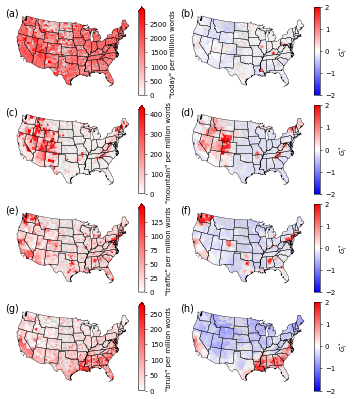

In [263]:
lang = list_langs[0]
words = ['today', 'mountain', 'traffic', 'bruh']
fig = plt.figure(figsize=(17.8/2.54, 20/2.54), constrained_layout=True, dpi=300)
mosaic = [
    [alphabet[2*i], f'{alphabet[2*i]}_cbar', alphabet[2*i+1], f'{alphabet[2*i+1]}_cbar']
    for i in range(len(words))
]
axd = fig.subplot_mosaic(
    mosaic, gridspec_kw={'width_ratios': [1, 0.05, 1, 0.05]}
)

for i, word in enumerate(words):
    letter = alphabet[2*i]
    cbar_label = f'"{word}" per million words'
    is_regional = lang.global_counts['is_regional']
    word_idx = lang.global_counts.loc[is_regional].index.get_loc(word)
    z_plot = 1e6 * lang.word_counts_vectors[:, word_idx] / lang.word_counts_vectors.cell_sums

    ax = axd[letter]
    cax = axd[f'{letter}_cbar']
    vmin = 0 
    vmax = np.percentile(z_plot, 95)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    #generate colors from original colormap in the range equivalent to [vmin, vamx] 
    cmap = plt.get_cmap('bwr')
    colors = cmap(np.linspace(0.5, 1., cmap.N))
    # Create a new colormap from those colors
    cmap = mcolors.LinearSegmentedColormap.from_list('cut_bwr', colors)

    lang.map_continuous_choro(
        z_plot, cmap=cmap, norm=norm, cbar_label=cbar_label, axes=ax, cax=cax,
        normed_bboxes=False, show=False, rasterized=True,
        cbar_kwargs={'extend': 'max'}
    )
    ax.set_title(None)

    letter = alphabet[2*i+1]
    norm = mcolors.CenteredNorm(halfrange=2)
    ax = axd[letter]
    cax = axd[f'{letter}_cbar']
    lang.map_word(
        word, axes=ax, cax=cax, normed_bboxes=False, show=False, norm=norm, rasterized=True, vmin=vmin, vmax=vmax,
    )
    cax.yaxis.set_label_text(r'$G_i^*$')
    ax.set_title(None)

for key, ax in axd.items():
    if not 'cbar' in key:
        art = ax.annotate(f'({key})', (-0.05, 0.95), xycoords='axes fraction', size=14)

save_path = lang.paths.case_figs / 'example_words_maps.pdf'
fig.savefig(save_path)
fig.savefig(save_path.with_suffix('.png'))
fig.set_dpi(50)
fig.show()

# PCA

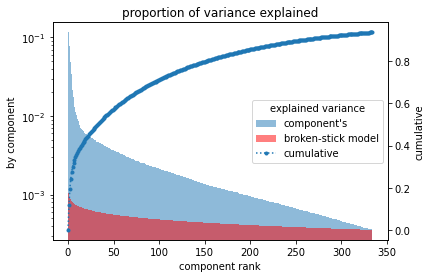

In [320]:
decomp = lang.make_decomposition()
fig, ax = decomp.explained_var_plot(
    lgd_kwargs={'loc': "center right", 'bbox_to_anchor': [1, 0.5]},
    #n_components=10)
)

In [126]:
import sklearn
X = lang.word_vectors.copy()
fa = sklearn.decomposition.FactorAnalysis(n_components=5, rotation='varimax')

In [127]:
fa.fit(X)

FactorAnalysis(n_components=5, rotation='varimax')

In [128]:
proj_vectors = fa.transform(X)

In [129]:
proj_vectors.shape

(2576, 5)

(<Figure size 504.567x229.606 with 2 Axes>,
 array([<AxesSubplot:title={'center':'the USA'}>], dtype=object))

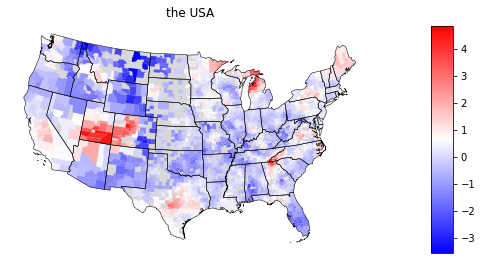

In [137]:
lang.map_continuous_choro(proj_vectors[:, 4], cmap='bwr',)

In [123]:
lang.decompositions.append(data_clustering.Decomposition(lang.word_counts_vectors, lang.word_vectors, fa, proj_vectors, lang.global_counts['cell_counts_mask']))

In [100]:
words_index = lang.global_counts.loc[lang.global_counts['cell_counts_mask']].index

In [ ]:
comps = fa.components_
i = 2
ascending = False
top_loadings = pd.Series(comps[i, :], index=words_index).sort_values(ascending=ascending)#, key=np.abs)
print(top_loadings.head(20))
print(top_loadings.tail(20))

In [ ]:
top_loadings.tail(20)

In [305]:
decomp.decomposition.n_components_

319

varimax?

In [141]:
lang = list_langs[0]
decomp = lang.decompositions[0]

In [143]:
import sklearn
comp_matrix = sklearn.decomposition._factor_analysis._ortho_rotation(decomp.decomposition.components_.T)

In [168]:
comp_matrix.shape

(319, 9432)

just take first 5


In [219]:
import copy
small_decomp = copy.deepcopy(decomp)

In [145]:
stored_comps = decomp.decomposition.components_.copy()
stored_vectors = decomp.proj_vectors.copy()
decomp.decomposition.components_ = comp_matrix
decomp.proj_vectors = decomp.decomposition.transform(lang.word_vectors)

In [221]:
stored_vectors.shape

(2576, 319)

In [223]:
small_decomp.proj_vectors = stored_vectors[:, :5]
small_decomp.decomposition.components_ = stored_comps[:5, :]
small_decomp.decomposition.components_ = sklearn.decomposition._factor_analysis._ortho_rotation(small_decomp.decomposition.components_.T)
small_decomp.proj_vectors = small_decomp.decomposition.transform(lang.word_vectors)
small_decomp.n_components = 5

In [231]:
# loadings = lang.global_counts.loc[lang.global_counts['is_regional']].copy()
loadings = lang.global_counts.loc[small_decomp.word_mask].copy()
comps = small_decomp.decomposition.components_
comp_loadings = pd.DataFrame(
    {f'comp{i_comp}_load': comps[i_comp] for i_comp in range(small_decomp.n_components)},
    index=loadings.index
)
loadings = pd.concat([loadings, comp_loadings], axis=1)

In [239]:
i_comp = 2
ascending = True
top_loadings = loadings.sort_values(by=f'comp{i_comp}_load', ascending=ascending)#, key=np.abs)
top_loadings.head(20)

,count,is_proper,nr_cells,cell_counts_mask,is_regional,comp0_load,comp1_load,comp2_load,comp3_load,comp4_load
word,,,,,,,,,,
genesis,151650.0,0.0,27553.930010,True,True,-0.000464,-0.008655,-0.144524,-0.000570,0.002473
full,7467467.0,0.0,155527.783378,True,True,-0.003509,-0.015587,-0.115039,-0.007038,-0.004404
healthcare,1258934.0,0.0,73519.860698,True,True,0.012249,0.002954,-0.103590,0.000625,0.001470
compassion,283767.0,0.0,46277.341107,True,True,-0.006214,-0.006269,-0.102005,-0.006621,-0.002930
nursing,616882.0,0.0,70009.733460,True,True,0.016281,-0.014617,-0.099657,-0.000842,0.010584
ordering,373654.0,0.0,54886.577642,True,True,0.003173,0.000828,-0.098595,0.005737,0.008278
discipline,178509.0,0.0,39093.852803,True,True,0.004787,-0.004642,-0.098306,-0.008637,0.012040
engagement,371635.0,0.0,50609.847625,True,True,-0.002564,0.011868,-0.097104,-0.005985,0.010328
certified,522887.0,0.0,59154.158794,True,True,-0.011005,-0.006222,-0.095011,0.010584,0.015578


var

In [177]:
lang.word_vectors.var(axis=0).sum()

WordVectors(1513.48939818)

In [181]:
stored_vectors.var(axis=0)

array([208.52360945, 131.68313451,  88.10511874,  55.48864945,
        30.86889487,  29.01407248,  24.49400393,  19.72058162,
        15.54074654,  14.42268274,  12.60809054,  12.28956044,
        11.15660562,  10.42039572,  10.29725045,  10.04134486,
         9.65397209,   9.50935087,   9.24668539,   8.67895925,
         8.53688313,   8.41828447,   8.29243931,   8.11790604,
         7.89662851,   7.75667227,   7.39140992,   7.30838918,
         7.18299593,   7.12647217,   6.98676068,   6.82097938,
         6.669149  ,   6.55277237,   6.31825339,   6.23043723,
         6.07589865,   5.96868864,   5.86984532,   5.81595779,
         5.78285115,   5.48924552,   5.4342278 ,   5.34744603,
         5.28181485,   5.25611825,   5.09666831,   5.06965618,
         4.96531903,   4.89045134,   4.85275554,   4.75051126,
         4.65388727,   4.62523936,   4.59951521,   4.53766081,
         4.48388851,   4.37629176,   4.32395127,   4.24985206,
         4.1892072 ,   4.17268899,   4.08568154,   4.03

In [217]:
decomp.decomposition.explained_variance_

array([208.60458949, 131.73427359,  88.13933432,  55.51019844,
        30.88088279,  29.02534008,  24.50351616,  19.7282401 ,
        15.54678178,  14.42828378,  12.61298689,  12.29433309,
        11.16093828,  10.42444248,  10.30124938,  10.04524442,
         9.6577212 ,   9.51304382,   9.25027634,   8.68232972,
         8.54019842,   8.42155371,   8.29565967,   8.12105862,
         7.89969516,   7.75968457,   7.39428037,   7.31122739,
         7.18578544,   7.12923973,   6.98947398,   6.8236283 ,
         6.67173896,   6.55531714,   6.32070708,   6.23285681,
         6.07825823,   5.97100658,   5.87212487,   5.81821641,
         5.78509691,   5.49137727,   5.43633818,   5.34952271,
         5.28386604,   5.25815946,   5.0986476 ,   5.07162498,
         4.96724731,   4.89235055,   4.8546401 ,   4.75235612,
         4.6556946 ,   4.62703557,   4.60130143,   4.539423  ,
         4.48562983,   4.37799129,   4.32563047,   4.25150249,
         4.19083408,   4.17430945,   4.08726821,   4.04

Text(0.5, 0, 'component rank')

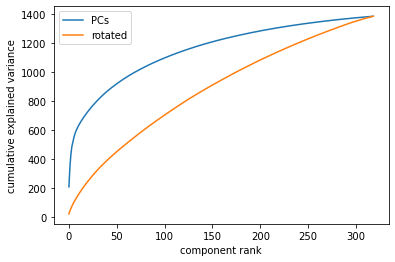

In [218]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(decomp.proj_vectors.shape[1]),
    decomp.decomposition.explained_variance_.cumsum(),
    # np.sort(stored_vectors.var(axis=0))[::-1].cumsum(),
    label='PCs'
)
ax.plot(
    np.arange(decomp.proj_vectors.shape[1]), 
    np.sort(decomp.proj_vectors.var(axis=0))[::-1].cumsum(),
    label='rotated'
)
ax.legend()
ax.set_ylabel('cumulative explained variance')
ax.set_xlabel('component rank')

Text(0.5, 0, 'component rank')

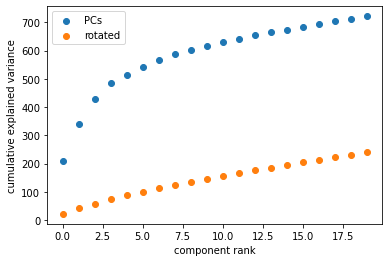

In [216]:
fig, ax = plt.subplots()
ax.scatter(
    np.arange(decomp.proj_vectors.shape[1])[:20], 
    np.sort(stored_vectors.var(axis=0))[::-1].cumsum()[:20],
    label='PCs'
)
ax.scatter(
    np.arange(decomp.proj_vectors.shape[1])[:20], 
    np.sort(decomp.proj_vectors.var(axis=0))[::-1].cumsum()[:20],
    label='rotated'
)
ax.legend()
ax.set_ylabel('cumulative explained variance')
ax.set_xlabel('component rank')

In [201]:
np.argsort(decomp.proj_vectors.var(axis=0))[:-10:-1]

array([  0,  50, 167,   1,  16,   6, 289,  11, 201])

(<Figure size 504.567x229.606 with 2 Axes>,
 array([<AxesSubplot:title={'center':'the USA'}>], dtype=object))

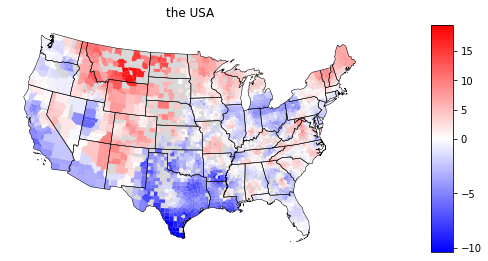

In [257]:
lang.map_continuous_choro(small_decomp.proj_vectors[:, 1], cmap='bwr', vcenter=0)

In [133]:
global_lang = list_langs[0]
decomp = lang.make_decomposition(from_other=global_lang)

In [846]:
lang = global_lang

In [187]:
decomp = lang.decompositions[0]
# loadings = lang.global_counts.loc[lang.global_counts['is_regional']].copy()
loadings = lang.global_counts.loc[decomp.word_mask].copy()
comps = decomp.decomposition.components_
comp_loadings = pd.DataFrame(
    {f'comp{i_comp}_load': comps[i_comp] for i_comp in range(decomp.n_components)},
    index=loadings.index
)
loadings = pd.concat([loadings, comp_loadings], axis=1)

In [232]:
i_comp = 289
ascending = True
top_loadings = loadings.sort_values(by=f'comp{i_comp}_load', ascending=ascending)#, key=np.abs)
top_loadings.head(20)

,count,is_proper,nr_cells,cell_counts_mask,is_regional,comp0_load,comp1_load,comp2_load,comp3_load,comp4_load
word,,,,,,,,,,
pig,386760.0,0.0,57523.492440,True,True,-0.057032,-0.006282,-0.002026,0.003625,-0.008726
gore,97786.0,0.0,25640.334613,True,True,-0.056073,-0.010447,0.002556,0.005692,-0.005520
smith,882169.0,0.0,79172.926333,True,True,-0.055657,0.013889,-0.002031,-0.007374,0.005391
needy,93834.0,0.0,29640.482337,True,True,-0.054807,-0.003806,0.004333,0.018773,0.002773
mavs,95811.0,0.0,17210.664627,True,True,-0.052845,-0.002506,-0.004665,-0.004643,0.002605
yell,382111.0,0.0,60114.472506,True,True,-0.050040,-0.001694,-0.015284,0.001521,-0.009545
jean,167212.0,0.0,36593.370133,True,True,-0.048781,0.017963,-0.002302,-0.016817,0.005231
fort,521884.0,0.0,53027.609331,True,True,-0.039126,0.007411,0.013235,0.014944,0.006889
freaking,1207660.0,0.0,97826.419236,True,True,-0.039035,-0.010293,0.014229,-0.004302,0.015532


In [ ]:
loadings.loc[:, ['count'] + [f'comp{i}_load' for i in range(5)]].to_csv('comp_words.csv')

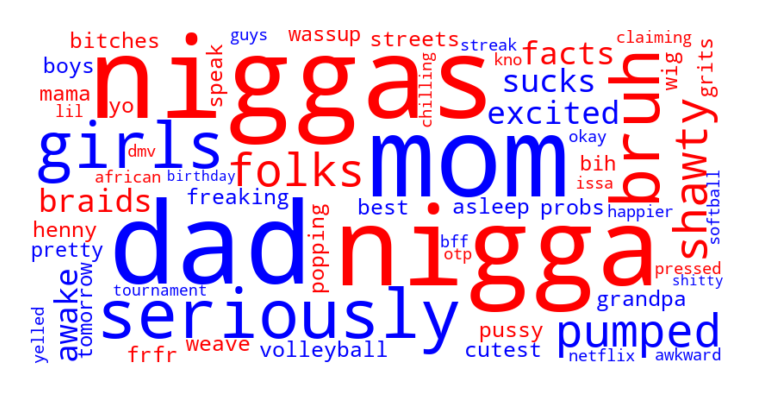

In [849]:
top_loadings = loadings[f'comp{i_comp}_load'].sort_values(ascending=True)
word_weights = top_loadings.iloc[:30] / top_loadings.iloc[0]
word_weights = word_weights.append(top_loadings.iloc[-30:] / top_loadings.iloc[-1])

def color_func(word, font_size, position, orientation, font_path, random_state):
    if top_loadings.loc[word] > 0:
        return (255, 0, 0)
    else:
        return (0, 0, 255)

figsize = (3, 1.5)
save_path = None #(lang.paths.case_figs / f"word_cloud_comp{i_comp}.png")
_ = word_viz.cloud(word_weights, color_func=color_func, figsize=figsize, save_path=save_path)

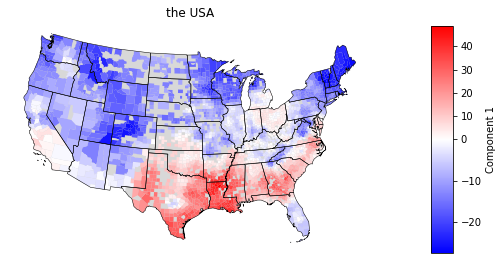

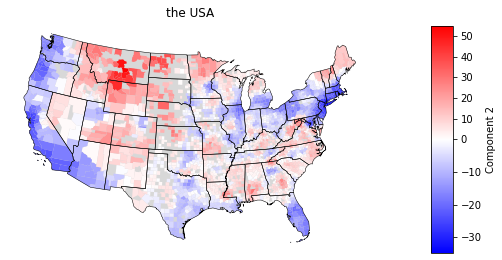

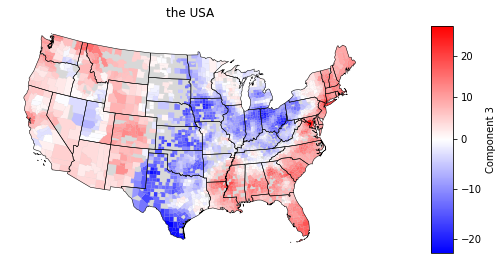

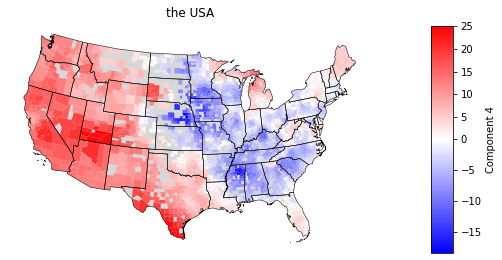

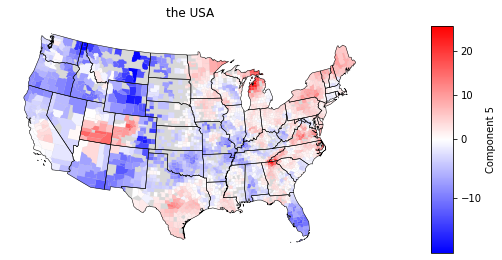

In [226]:
lang.map_comp(comps=range(5), i_decompo=0)

## Composite plot for paper

In [321]:
lang = list_langs[0]
decomp = lang.decompositions[-1]
proj_vectors = decomp.proj_vectors
loadings = lang.global_counts.loc[decomp.word_mask].copy()
comps = decomp.decomposition.components_
comp_loadings = pd.DataFrame(
    {f'comp{i_comp}_load': comps[i_comp] for i_comp in range(decomp.n_components)},
    index=loadings.index
)
loadings = pd.concat([loadings, comp_loadings], axis=1)

i_comp = 1
top_loadings = loadings[f'comp{i_comp}_load'].sort_values(ascending=True)
word_weights = top_loadings.iloc[:30] / top_loadings.iloc[0]
word_weights = word_weights.append(top_loadings.iloc[-30:] / top_loadings.iloc[-1])
print(str(decomp))

word_counts_vectors=nr_tokens_bw=None_presence_th=None_max_word_rank=None_smooth_wdist_fun=None_smooth_wdist_fun_kwargs={}_word_vectors=word_vec_var=Gi_star(w=DistanceBand(threshold=100000.0))_decomposition=PCA()_n_components=334


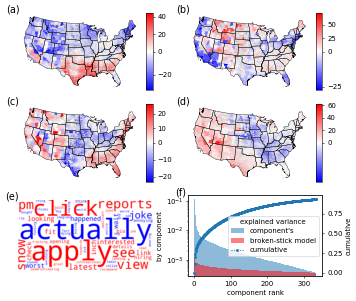

In [322]:
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(17.8/2.54, 15/2.54), constrained_layout=True,
    gridspec_kw={'height_ratios': [1, 1, 1]}, dpi=300
)
for i, ax in enumerate(axes[:2, :].flat):
    cbar_label = f'Component {i+1}'
    cbar_label = ' '
    z_plot = proj_vectors[:, i]
    fig, _ = lang.map_continuous_choro(
        z_plot, cmap='bwr', cbar_label=cbar_label, vcenter=0, axes=ax, normed_bboxes=False,
        rasterized=True,# cbar_kwargs={'rasterized': True}
    )
    ax.set_title(None)

ax = axes[-1, 0]
def color_func(word, font_size, position, orientation, font_path, random_state):
    if top_loadings.loc[word] > 0:
        return (255, 0, 0)
    else:
        return (0, 0, 255)

fig, ax = word_viz.cloud(word_weights, color_func=color_func, ax=ax)

ax = axes[-1, -1]
fig, ax = decomp.explained_var_plot(
    ax=ax,
    lgd_kwargs={'loc': "center right", 'bbox_to_anchor': [1, 0.5]},
)
ax.set_title(None)
for i, ax in enumerate(axes.flat):
    art = ax.annotate(f'({alphabet[i]})', (-0.1, 1), xycoords='axes fraction', fontsize=14)
save_path = lang.paths.case_figs / f'decomp_{decomp.word_vectors}.pdf'
fig.savefig(save_path)
fig.savefig(save_path.with_suffix('.png'))
fig.set_dpi(50)
fig.show()

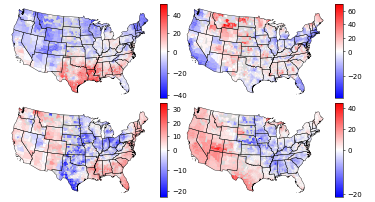

In [314]:
for lang in [list_langs[0]]:
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(17.8/2.54, 10/2.54), constrained_layout=True,
        dpi=300
    )
    decomp = lang.decompositions[-1]
    # # fig.set_constrained_layout_pads(w_pad=0, wspace=0)
    for i, ax in enumerate(axes.flat):
        cbar_label = f'Component {i+1}'
        cbar_label = ' '
        z_plot = decomp.proj_vectors[:, i]
        fig, _ = lang.map_continuous_choro(
            z_plot, cmap='bwr', cbar_label=cbar_label, vcenter=0, axes=ax, normed_bboxes=False,
            rasterized=True,# cbar_kwargs={'rasterized': True}
        )
        ax.set_title(None)

    save_path = Path(str(lang.paths.decomp_fig_fmt).format(
        **lang.to_dict(),
        **decomp.word_counts_vectors.to_dict(),
        **decomp.word_vectors.to_dict(),
        component='1-4',
        **asdict(decomp),
    ))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, bbox_inches='tight')
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.set_dpi(50)
    fig.show()

# Clustering

Rank words for eg the southern cluster by most characteristic, how these change over time (words appear?)

In [334]:
agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
max_n_clusters = 30
clustering = lang.decompositions[0].add_scipy_hierarchy(
    lang.relevant_cells, max_n_clusters=max_n_clusters, **agg_clustering_params
)

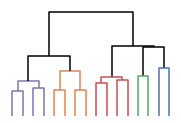

In [116]:
fig, ax = plt.subplots(figsize=(3, 2))
clustering.levels[3].attr_color_to_labels()
fig, ax = clustering.plot_dendrogram(coloring_lvl=3, ax=ax)#, orientation='left')
ax.set_axis_off()
fig.savefig('dendrogram.pdf')

## Maps

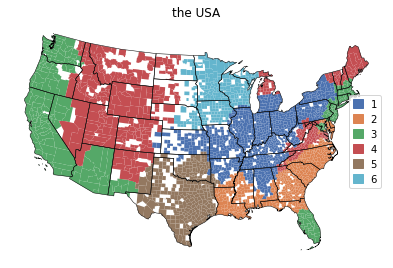

In [435]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, levels_subset=[4])

## Words

In [413]:
i_lvl = 0
clust_words = lang.get_clust_words(i_clust=-1, i_lvl=i_lvl)

In [414]:
clust_nr = 1
coord_col = f'cluster{clust_nr}'
dist_col = f'dist{clust_nr}'
clust_words[f'spec{clust_nr}'] = clust_words[dist_col] #* np.log(clust_words['count'])
# without coord > 0 filter, as south cluster is strongest,  others are thus
# first characterised as not having this cluster's words. Hence the need to
# filter.
top_clust_words = clust_words.sort_values(
    by=f'spec{clust_nr}', key=np.abs, ascending=False
)[['count', coord_col, dist_col]]
top_clust_words.loc[clust_words[coord_col] > 0].head(10)

,count,cluster1,dist1
word,,,
hoe,2041967.0,0.876200,1.685297
tf,3509989.0,0.873263,1.668024
nigga,5874107.0,0.874386,1.666487
lil,4451331.0,0.863090,1.626759
hoes,2392468.0,0.852489,1.587799
nerves,360412.0,0.850095,1.578865
females,1075190.0,0.840881,1.534982
niggas,5856390.0,0.827905,1.487852
fw,959687.0,0.816970,1.463828


distance or correlation matrix between clusters

In [415]:
decomp = lang.decompositions[0]
clustering = decomp.clusterings[-1]
level = clustering.levels[i_lvl]
list_clust_words = []
for clust_nr in level.labels.unique():
    coord_col = f'cluster{clust_nr}'
    dist_col = f'dist{clust_nr}'
    clust_words[f'spec{clust_nr}'] = clust_words[dist_col] #* np.log(clust_words['count'])
    # without coord > 0 filter, as south cluster is strongest,  others are thus
    # first characterised as not having this cluster's words. Hence the need to
    # filter.
    top_clust_words = clust_words.sort_values(
        by=f'spec{clust_nr}', key=np.abs, ascending=False
    )[['count', coord_col, dist_col]]
    list_clust_words.append(
        top_clust_words.loc[clust_words[coord_col] > 0, dist_col].rename('dist').iloc[:20].to_frame().assign(cluster=str(clust_nr))
    )

clust_words_df = pd.concat(list_clust_words)
# normalize
clust_words_df['normed_dist'] = (
    clust_words_df['dist']
    / clust_words_df.groupby('cluster')['dist'].transform('max')
)

In [210]:
lang.relevant_cells.shape

(2458,)

In [159]:
def color_func(word, font_size, position, orientation, font_path, random_state):
    return tuple((np.asarray(level.colors[clust_words_df.loc[word].cluster]) * 255).astype(int))

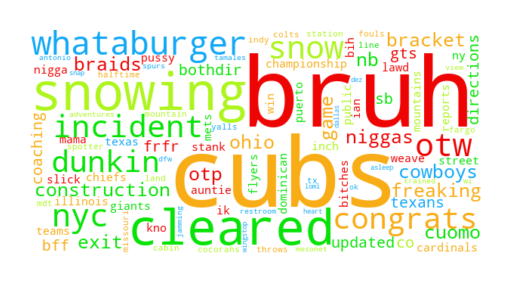

In [168]:
_ = word_viz.cloud(clust_words_df['normed_dist'], color_func=color_func, figsize=(2, 1))

In [ ]:
decomposition = lang.decompositions[-1]
level = decomposition.clusterings[-1].levels[i_lvl]

total_width = 178
# normed_bboxes, (total_width, total_height) = lang.get_maps_pos(
#     total_width, total_height=None
# )
# normed_bboxes[2:] = normed_bboxes[2:] / 2
normed_bboxes = np.array([[0, 0.5, 1, 0.5]])
figsize = (total_width/10/2.54, 2*total_height/10/2.54)
fig, axes = plt.subplots(2, 1, figsize=figsize, dpi=300)
fig, axes[0] = map_viz.cluster_level(
    level, lang.regions, normed_bboxes,
    show=False, fig=fig, axes=axes[0],
)

def color_func(word, font_size, position, orientation, font_path, random_state):
    return tuple((np.asarray(level.colors[clust_words_df.loc[word].cluster]) * 255).astype(int))

fig, axes[1] = word_viz.cloud(clust_words_df['normed_dist'], color_func=color_func, fig=fig, ax=axes[1])
fmt_dict = {**lang.to_dict(),
            **asdict(decomposition),
            **decomposition.word_counts_vectors.to_dict(),
            **decomposition.word_vectors.to_dict(),
            **asdict(level)}
save_path = Path(str(lang.paths.cluster_fig_fmt.with_suffix('.png')).format(**fmt_dict))

fig.savefig(save_path)

In [ ]:
list_df = []
# for clust_nr, clust_stem_data in stem_data.groupby('cluster'):
for clust_nr in level.labels.unique():
    top_words_spec = clust_words[f'spec{clust_nr}'].rename('spec').nlargest(n=5)
    mask = clust_words.loc[top_words_spec.index, f'cluster{clust_nr}'] < 0
    top_words_spec.loc[mask] = -top_words_spec.loc[mask]
    df = pd.DataFrame({'spec': top_words_spec, 'clust_nr': clust_nr}, index=top_words_spec.index)
    list_df.append(df)

spec_words_df = pd.concat(list_df)
spec_words_df['y_pos'] = spec_words_df['spec'].abs().rank()

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
for clust_nr, df in spec_words_df.groupby('clust_nr'):
    c = level.colors[clust_nr]
    y_pos = df['y_pos'].values
    heads = df['spec'].values
    markerline, stemlines, baseline = ax.stem(
        y_pos, heads, orientation='horizontal', basefmt='none'
    )
    stemlines.set_color(c)
    markerline.set_color(c)
ax.set_yticks(spec_words_df['y_pos'].values, labels=stem_data.index.values)
# ax.invert_yaxis()
ax.set_xlabel('specificity')
# # ax.grid(True)
# fig.savefig(lang.paths.case_figs / f'top_characteristic_words_lvl={i_lvl}.pdf')

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
for clust_nr in level.labels.unique():
    specs = clust_words[f'spec{clust_nr}']
    nr_bins = 20
    # bins = np.logspace(np.log10(specs.min()), np.log10(specs.max()), 20)
    bins = nr_bins
    y_plot, bin_edges = np.histogram(specs, bins=bins)
    x_plot = (bin_edges[:-1] + bin_edges[1:]) / 2
    # x_plot = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    ax.scatter(x_plot, y_plot, color=level.colors[clust_nr], label=clust_nr)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('specificity')
ax.set_ylabel('frequency')
ax.legend()

In [273]:
for clust_nr in level.labels.unique():
    print(clust_nr, clust_words[f'spec{clust_nr}'].sum())

1 321.992085633978
2 76.3880763965345
3 171.9352238754369
4 241.8100645252279
5 183.4762127707005


In [ ]:
stem_data = clust_words_df.groupby('cluster').head(5).sort_values(by='dist', ascending=False)
stem_data['iloc'] = np.arange(len(stem_data))
fig, ax = plt.subplots(1, constrained_layout=True)
# spec_series = pd.Series(index=clust_words.index, )
# for clust_nr, clust_stem_data in stem_data.groupby('cluster'):
for clust_nr in level.labels.unique():
    c = level.colors[clust_nr]
    clust_words.sort_values(
        by=f'spec{clust_nr}', key=np.abs, ascending=False
    )[f'spec{clust_nr}']
    y_pos = clust_stem_data['iloc'].values
    heads = clust_stem_data['dist'].values
    markerline, stemlines, baseline = ax.stem(
        y_pos, heads, orientation='horizontal', basefmt='none'
    )
    stemlines.set_color(c)
    markerline.set_color(c)
ax.set_yticks(stem_data['iloc'].values, labels=stem_data.index.values)
ax.invert_yaxis()
ax.set_xlabel('specificity')
# ax.grid(True)
fig.savefig(lang.paths.case_figs / f'top_characteristic_words_lvl={i_lvl}.pdf')


In [ ]:
word = 'nigga'
clusters = list_langs[0].decompositions[0].clusterings[0].levels[0].labels
list_v = []
list_y = []
list_clusters = []
list_years = []
for l in list_langs[1:]:
    print(l.year_from)
    is_regional = l.global_counts['is_regional']
    word_idx = l.global_counts.loc[is_regional].index.get_loc(word)
    decomp = l.decompositions[-1]
    # p = decomp.proj_vectors[:, 0]
    # cell_mask = p >  np.percentile(p, 90)
    cell_mask = slice(None)
    v = (l.word_counts_vectors.T / l.word_counts_vectors.cell_sums).T
    print(v.mean())
    global_prop = l.global_counts.loc[word, 'count'] / l.global_counts['count'].sum()
    print(global_prop)
    v = v[cell_mask, word_idx] / global_prop
    list_v.append(v)
    list_y.extend(v.flatten().tolist())
    list_years.extend([l.year_from] * l.relevant_cells.size)
    list_clusters.extend(clusters.reindex(l.relevant_cells).fillna('unknown').values.tolist())


fig, ax = plt.subplots()
# _ = ax.violinplot(
#     list_v,
#     showextrema=False, showmedians=True, quantiles=[[0.25,  0.75]]*len(list_v)
# )
_ = ax.boxplot(
    list_v,
    # showextrema=False, showmedians=True, quantiles=[[0.25,  0.75]]*len(list_v)
)
ax.set_yscale('log')

In [ ]:
import seaborn as sns

In [235]:
data = pd.DataFrame({'prop': list_y, 'year': list_years, 'cluster': list_clusters})

In [410]:
common_cells = pd.Series(1, index=lang.relevant_cells)
for l in list_langs[:7]:
    common_cells = common_cells.add(pd.Series(1, index=l.relevant_cells))
common_cells = common_cells.loc[common_cells.notnull()].index

In [ ]:
from collections import defaultdict

all_years_clustering = lang.decompositions[0].clusterings[0].levels[0]
clusters = all_years_clustering.labels
metric_label = 'prop - global prop'
# rnd_index = (np.random.random(10) * top_clust_words.shape[0]).astype(int)
for word in top_clust_words.index[:10]:
    
    plot_dict = defaultdict(list)
    for l in list_langs[:7]:
        is_regional = l.global_counts['is_regional']
        word_idx = l.global_counts.loc[is_regional].index
        if word not in word_idx:
            print(f'{word} not in {l.year_from}-{l.year_to}')
            continue
        word_idx = word_idx.get_loc(word)
        decomp = l.decompositions[0]
        # cell_mask = slice(None)
        cell_mask = pd.Series(
            range(l.relevant_cells.size), index=l.relevant_cells
        ).loc[common_cells].values
        # this is fro raw_cell_counts so everything, this way same basis
        cell_sums = l.word_counts_vectors.cell_sums
        v = (l.word_counts_vectors.T / cell_sums).T
        global_prop = l.global_counts.loc[word, 'count'] / cell_sums.sum()
        # v = v[cell_mask, word_idx] / global_prop
        # v = 1 + v[cell_mask, word_idx] - global_prop
        v = v[cell_mask, word_idx] - global_prop
        plot_dict['global_prop'].append(global_prop) 
        plot_dict['v'].append(v)
        plot_dict[metric_label].extend(v.flatten().tolist())
        plot_dict['year'].extend([l.year_from] * common_cells.size)
        plot_dict['cluster'].extend(clusters.reindex(common_cells).fillna('unknown').values.tolist())

    if plot_dict['global_prop'][0] > plot_dict['global_prop'][-1]:
        continue
    
    data = pd.DataFrame({
        k: v for k, v in plot_dict.items() if k in [metric_label, 'year', 'cluster']
    })
    
    fig, ax = plt.subplots(constrained_layout=True)
    colors = all_years_clustering.colors
    ax = sns.boxenplot(
        data=data.loc[data['cluster'] != 'unknown'],
        x='year', y=metric_label, hue='cluster', palette=colors, showfliers=False
    )

    ax.set_title(word)
    # ax.set_yscale('log')
    ax2 = ax.twinx()
    global_props = plot_dict['global_prop']
    ax2.scatter(range(len(global_props)), global_props, c='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylabel('global prop', color='tab:blue')
    # fig.savefig(lang.paths.case_figs / f'{word}_evolution.pdf')

In [ ]:
from collections import defaultdict

all_years_clustering = lang.decompositions[0].clusterings[0].levels[0]
clusters = all_years_clustering.labels
metric_label = 'prop - global prop'
# rnd_index = (np.random.random(10) * top_clust_words.shape[0]).astype(int)
for word in top_clust_words.index[:20]:
    
    plot_dict = defaultdict(list)
    for l in list_langs[:7]:
        is_regional = l.global_counts['is_regional']
        word_idx = l.global_counts.loc[is_regional].index
        if word not in word_idx:
            print(f'{word} not in {l.year_from}-{l.year_to}')
            continue
        word_idx = word_idx.get_loc(word)
        decomp = l.decompositions[0]
        # cell_mask = slice(None)
        cell_mask = pd.Series(
            range(l.relevant_cells.size), index=l.relevant_cells
        ).loc[common_cells].values
        # this is fro raw_cell_counts so everything, this way same basis
        cell_sums = l.word_counts_vectors.cell_sums
        v = (l.word_counts_vectors.T / cell_sums).T
        global_prop = l.global_counts.loc[word, 'count'] / cell_sums.sum()
        # v = v[cell_mask, word_idx] / global_prop
        # v = 1 + v[cell_mask, word_idx] - global_prop
        v = v[cell_mask, word_idx] - global_prop
        plot_dict['global_prop'].append(global_prop) 
        plot_dict['v'].append(v)
        plot_dict[metric_label].extend(v.flatten().tolist())
        plot_dict['year'].extend([l.year_from] * common_cells.size)
        plot_dict['cluster'].extend(clusters.reindex(common_cells).fillna('unknown').values.tolist())

    if plot_dict['global_prop'][0] > plot_dict['global_prop'][-1]:
        continue
    
    data = pd.DataFrame({
        k: v for k, v in plot_dict.items() if k in [metric_label, 'year', 'cluster']
    })
    
    fig, ax = plt.subplots(constrained_layout=True)
    colors = all_years_clustering.colors
    ax = sns.boxenplot(
        data=data.loc[data['cluster'] != 'unknown'],
        x='year', y=metric_label, hue='cluster', palette=colors,
    )

    ax.set_title(word)
    # ax.set_yscale('log')
    ax2 = ax.twinx()
    global_props = plot_dict['global_prop']
    ax2.scatter(range(len(global_props)), global_props, c='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylabel('global prop', color='tab:blue')
    # fig.savefig(lang.paths.case_figs / f'{word}_evolution.pdf')

In [245]:
rankings = []
for l in list_langs[:-1]:
    i_lvl = 0
    clust_words = l.get_clust_words(i_decompo=0, i_clust=-1, i_lvl=i_lvl)
    top_words = clust_words.loc[clust_words['cluster1'] > 0, 'dist1'].nlargest(n=20)
    rankings.append(
        top_words.to_frame()
         .assign(
            year=f'{l.year_from}-{l.year_to}',
            rank=top_words.rank(ascending=False),
         )
        .reset_index()
    )
ranks_df = pd.concat(rankings).set_index(['word', 'year']).sort_index()
ranks_df

dist1  rank
word     year                     
af       2019-2019  0.914728  18.0
         2020-2020  0.899111  17.0
asf      2016-2016  0.829011  19.0
         2017-2017  1.382209  11.0
         2018-2018  1.043364  11.0
...                      ...   ...
tripping 2015-2015  0.879430  20.0
yalls    2016-2016  0.981254  12.0
yo       2017-2017  1.199747  19.0
         2020-2020  0.904810  16.0
         2021-2021  0.834971  19.0

[140 rows x 2 columns]

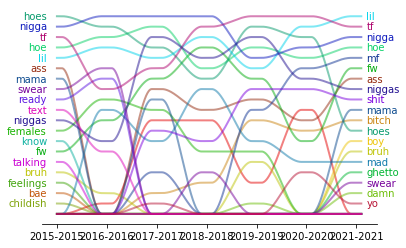

In [289]:
from collections import defaultdict
from scipy import interpolate
def add_widths(x, y, width=0.1):
    """ Adds flat parts to widths """
    new_x = []
    new_y = []
    for i,j in zip(x,y):
        new_x += [i-width, i, i+width]
        new_y += [j, j, j]
    return new_x, new_y

year_ranges = ranks_df.index.levels[1]
# selcet words in top 10 either at end or start
loc = (slice(None), [year_ranges[0], year_ranges[-1]])
selected_words = ranks_df.loc[loc, :].index.get_level_values('word').unique()
max_rank = ranks_df['rank'].max()
fig, ax = plt.subplots()
# cmap = plt.get_cmap('plasma', selected_words.size)
colors = map_viz.gen_distinct_colors(selected_words.size, mean_lightness=30)
cmap = colors.__getitem__
# r = dataframe.rank(method="first")
# r = (r - r.max() + r.max().max()).fillna(0) # Sets NAs to 0 in rank
for i, word in enumerate(selected_words):
    color = cmap(i)
    x = np.arange(year_ranges.size)
    y = 1 + max_rank - ranks_df.loc[word, 'rank'].reindex(year_ranges).fillna(max_rank)
    # color = color_dict[i]
    # lw = linewidth_dict[i]
    x, y = add_widths(x, y, width=0.1)
    xs = np.linspace(0, x[-1], num=1024)
    ax.plot(xs, interpolate.PchipInterpolator(x, y)(xs), c=color, linewidth=2, alpha=0.5)
    if y[0] > 1:
        ax.text(x[0] - 0.1, y[0], s=word, ha="right", va="center", color=color)
    if y[-1] > 1:
        ax.text(x[-1] + 0.1, y[-1], s=word, ha="left", va="center", color=color)
fig.patch.set_facecolor('#FFFFFF') 
ax.set_xticks(np.arange(year_ranges.size), year_ranges)
ax.yaxis.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
fig.savefig(lang.paths.case_figs / 'ha.png')

In [ ]:
fig, ax = plt.subplots(1)
word = 'know'
x_plot = []
y_plot = []
for i_lang in range(len(list_langs)-1):
    lang = list_langs[i_lang]
    i_decompo = 0
    decomp = lang.decompositions[i_decompo]
    i_clust = 0
    clust = decomp.clusterings[i_clust]
    i_lvl = 0
    level = clust.levels[i_lvl]
    clust_words = lang.get_clust_words(i_decompo=i_decompo, i_clust=i_clust, i_lvl=i_lvl)

    x_plot.append(f'{lang.year_from}-{lang.year_to}')
    y_plot.append(clust_words.loc[word, 'cluster1'])
    # for clust_nr, clust_stem_data in stem_data.groupby('cluster'):
    # for clust_nr in level.labels.unique():
    #     coord_col = f'cluster{clust_nr}'
    #     dist_col = f'dist{clust_nr}'
    #     clust_words[f'spec{clust_nr}'] = clust_words[dist_col]
    #     top_words_spec = clust_words.loc[clust_words[coord_col] > 0, f'spec{clust_nr}'].rename('spec').nlargest(n=5)
    #     # top_words_spec = clust_words[f'spec{clust_nr}'].rename('spec').nlargest(n=5)
    #     # mask = clust_words.loc[top_words_spec.index, f'cluster{clust_nr}'] < 0
    #     # top_words_spec.loc[mask] = -top_words_spec.loc[mask]
    #     df = pd.DataFrame({'spec': top_words_spec, 'clust_nr': clust_nr}, index=top_words_spec.index)
    #     list_df.append(df)

    # spec_words_df = pd.concat(list_df)
    # spec_words_df['y_pos'] = spec_words_df['spec'].abs().rank()

# c = level.colors[clust_nr]
markerline, stemlines, baseline = ax.stem(
    x_plot, y_plot, basefmt='k-' #'none'
)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(f'specificity of {word} in cluster 1')
# stemlines.set_color(c)
# markerline.set_color(c)

## Clustering scores

In [57]:
from itertools import combinations
import functools

import sklearn
from sklearn.metrics import pairwise_distances_chunked
from sklearn.metrics.cluster._unsupervised import _silhouette_reduce
from sklearn.metrics import pairwise_distances

In [136]:
global_lang = list_langs[0]
clustering = global_lang.decompositions[-1].clusterings[0].levels[0]

In [50]:
X = decomp.proj_vectors
labels = clustering.labels.values

le = sklearn.preprocessing.LabelEncoder()
labels = le.fit_transform(labels)
n_samples = len(labels)
label_freqs = np.bincount(labels)

reduce_func = functools.partial(
    _silhouette_reduce, labels=labels, label_freqs=label_freqs
)
intra_clust_dists, inter_clust_dists = zip(
    *pairwise_distances_chunked(X, reduce_func=reduce_func, metric='euclidean')
)
intra_clust_dists = np.concatenate(intra_clust_dists)
inter_clust_dists = np.concatenate(inter_clust_dists)

denom = (label_freqs - 1).take(labels, mode="clip")
with np.errstate(divide="ignore", invalid="ignore"):
    intra_clust_dists /= denom

In [385]:
max_inter_county_dist = pairwise_distances(proj_vectors).max()

evolution with time of pairwise distances between clusters. first attempt using cluster centers

In [68]:
common_cells = pd.Series(1, index=global_lang.relevant_cells)
for l in list_langs[1:]:
    common_cells = common_cells.add(pd.Series(1, index=l.relevant_cells))
common_cells = common_cells.loc[common_cells.notnull()].index

In [119]:
labels = clustering.labels
unique_labels = np.unique(labels)
nr_clusts = unique_labels.size
slice_years_select = slice(0, -1)

percentiles = np.array([[5, 10, 15, 20, 25]])
percentiles = np.append(percentiles, 100 - percentiles)
clust_pairs = [f'{t[0]}-{t[1]}' for t in combinations(unique_labels.sum(), 2)]
year_ranges = [f'{l.year_from}-{l.year_to}' for l in list_langs[slice_years_select]]
# dist_df = pd.DataFrame(index=pd.MultiIndex.from_product([clust_pairs, year_ranges]))
# dist_df = pd.DataFrame(index=clust_pairs)
dist_dict = {(y, pair): {} for pair in clust_pairs for y in year_ranges}
# dist_df = pd.DataFrame(columns=['pair', 'year', 'dist'])

for l in list_langs[slice_years_select]:
    boxplot_data = []
    year = f'{l.year_from}-{l.year_to}'
    # clust_dist_mat = np.zeros((unique_labels.shape[0], unique_labels.shape[0]))
    # percentiles_mats = {pc: clust_dist_mat.copy() for pc in percentiles}
    # 0 is normal, 1 is from global
    decomp = l.decompositions[0]
    df = pd.DataFrame({'global': True}, index=global_lang.relevant_cells)
    df = df.join(pd.Series(True, name='l', index=l.relevant_cells), how='outer')
    
    for i, lbl in enumerate(unique_labels):
        cluster_mask = labels == lbl
        df = df.join(cluster_mask.rename(f'clust{lbl}')).fillna(False)

    for pair in clust_pairs:
        i, j = pair.split('-')
    # for i, lbl in enumerate(unique_labels):
        df['combine'] = df['global'] & df['l'] & df[f'clust{i}']
        cluster_mask = df.loc[df['l'], 'combine'].values.nonzero()[0]
        clust_vectors = decomp.proj_vectors[cluster_mask, :]
        # iloc_other_labels = np.nonzero(unique_labels != lbl)[0]
        # for j in iloc_other_labels:
        # other_lbl = unique_labels[j]
        df['combine'] = df['global'] & df['l'] & df[f'clust{j}']
        cluster_mask = df.loc[df['l'], 'combine'].values.nonzero()[0]
        other_clust_vectors = decomp.proj_vectors[cluster_mask, :]
        pairwise_dist = pairwise_distances(clust_vectors, other_clust_vectors).flatten()
        boxplot_data.append(pairwise_dist)
        dist_dict[(year, pair)]['mean'] = pairwise_dist.mean()
        dist_dict[(year, pair)]['median'] = np.median(pairwise_dist)
        for p in percentiles:
            dist_dict[(year, pair)][f'{p}th_percentile'] = np.percentile(pairwise_dist, p)
    # dist_df[col] = [clust_dist_mat[i, j] for i in range(nr_clusts-1) for j in range(i+1, nr_clusts)]

dist_df = pd.DataFrame.from_dict(dist_dict, orient='index').rename_axis(['year_range', 'clust_pair'])

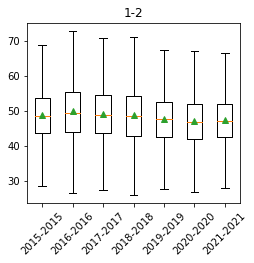

In [146]:
labels = clustering.labels
unique_labels = np.unique(labels)
nr_clusts = unique_labels.size
slice_years_select = slice(4, None)

percentiles = np.array([[5, 10, 15, 20, 25]])
percentiles = np.append(percentiles, 100 - percentiles)
clust_pairs = [f'{t[0]}-{t[1]}' for t in combinations(unique_labels.sum(), 2)]
year_ranges = [f'{l.year_from}-{l.year_to}' for l in list_langs[slice_years_select]]
# dist_df = pd.DataFrame(index=pd.MultiIndex.from_product([clust_pairs, year_ranges]))
# dist_df = pd.DataFrame(index=clust_pairs)
dist_dict = {(y, pair): {} for pair in clust_pairs for y in year_ranges}
# dist_df = pd.DataFrame(columns=['pair', 'year', 'dist'])

fig, axes = plt.subplots(len(clust_pairs), figsize=(8.7/2.54, 9/2.54*len(clust_pairs)), constrained_layout=True)
axes = np.atleast_1d(axes)
for pair, ax in zip(clust_pairs, axes):
    i, j = pair.split('-')
    boxplot_data = []
    # clust_dist_mat = np.zeros((unique_labels.shape[0], unique_labels.shape[0]))
    # percentiles_mats = {pc: clust_dist_mat.copy() for pc in percentiles}
    # 0 is from global, 1 is normal

    for l in list_langs[slice_years_select]:
        year = f'{l.year_from}-{l.year_to}'
        decomp = l.decompositions[-1]
        df = pd.DataFrame({'l': True}, index=l.relevant_cells)
        df = df.join(pd.Series(True, name='global', index=global_lang.relevant_cells), how='left').fillna(False)
        for lbl in unique_labels:
            cluster_mask = labels == lbl
            df = df.join(cluster_mask.rename(f'clust{lbl}')).fillna(False)

        df['combine'] = df['global'] & df['l'] & df[f'clust{i}']
        cluster_mask = df['combine'].values.nonzero()[0]
        clust_vectors = decomp.proj_vectors[cluster_mask, :]
        # clust_vectors = l.word_vectors[cluster_mask, :]
        df['combine'] = df['global'] & df['l'] & df[f'clust{j}']
        cluster_mask = df['combine'].values.nonzero()[0]
        other_clust_vectors = decomp.proj_vectors[cluster_mask, :]
        # other_clust_vectors = l.word_vectors[cluster_mask, :]
        pairwise_dist = pairwise_distances(clust_vectors, other_clust_vectors).flatten()
        boxplot_data.append(pairwise_dist)
        dist_dict[(year, pair)]['mean'] = pairwise_dist.mean()
        dist_dict[(year, pair)]['median'] = np.median(pairwise_dist)
        for p in percentiles:
            dist_dict[(year, pair)][f'{p}th_percentile'] = np.percentile(pairwise_dist, p)

    # fig = plt.figure(figsize=(8.7/2.54, 8.7/2.54), constrained_layout=True, dpi=50)
    # ax = fig.subplots()
    _ = ax.boxplot(boxplot_data, showfliers=False, showmeans=True)
    ax.set_xticklabels(year_ranges, rotation=45)
    ax.set_title(pair)
fig.show()

dist_df = pd.DataFrame.from_dict(dist_dict, orient='index').rename_axis(['year_range', 'clust_pair'])

plot first PC for 3 periods + dist evol

In [152]:
sns_df = pd.concat(pd.DataFrame({'period': y, 'dist': dist}) for y, dist in zip(year_ranges, boxplot_data))
sns_df['period'] = sns_df['period'].str.slice(0, 4)

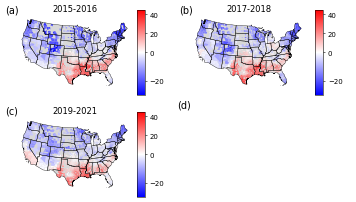

In [492]:
global_lang = list_langs[0]
mosaic = [
    ['a', 'ca', 'b', 'cb'],
    ['c', 'cc', 'd', 'd']
]
fig, axes = plt.subplot_mosaic(
    mosaic, figsize=(17.8/2.54, 10/2.54), constrained_layout=True,
    gridspec_kw={'width_ratios': [1, 0.07, 1, 0.07]}, dpi=300
)
letters = alphabet[:4]
for i, letter in enumerate(letters[:-1]):
    ax = axes[letter]
    cax = axes[f'c{letter}']
    lang = list_langs[i+2]
    cbar_label = ' '
    z_plot = lang.decompositions[-1].proj_vectors[:, 0]
    fig, _ = lang.map_continuous_choro(
        z_plot, cmap='bwr', cbar_label=cbar_label, vcenter=0, vmin=-30, vmax=45,
        axes=ax, cax=cax,
        normed_bboxes=False, rasterized=True,# cbar_kwargs={'rasterized': True}
    )
    ax.set_title(f'{lang.year_from}-{lang.year_to}')

ax = axes['d']
ax.set_axis_off()
ax = sns.boxplot(data=sns_df, x='period', y='dist', ax=ax, showfliers=False, color='w')
ax.set_xlabel(None)
ax.set_ylabel('inter-cluster distances')
for i, letter in enumerate(letters):
    art = axes[letter].annotate(f'({letter})', (-0.1, 1.05), xycoords='axes fraction', fontsize=14)
save_path = global_lang.paths.case_figs / 'evol_comp1_dists.pdf'
fig.savefig(save_path)
fig.savefig(save_path.with_suffix('.png'))
fig.set_dpi(50)
fig.show()

In [ ]:
n_pts = len(year_ranges)
n_plots = len(clust_pairs)
cmap = plt.cm.get_cmap('jet', n_plots)
colors = [cmap(i) for i in range(n_plots)]
x_plot = np.arange(1, n_pts+1)
y_mean = [dist_df.loc[(slice(None), cp), 'mean'].values for cp in clust_pairs]
ip = 0
p = 10 # percentiles[ip]
dist_df['top_bar_length'] = (
    dist_df[f'{100-p}th_percentile'] - dist_df['mean']
)
dist_df['bot_bar_length'] = (
    dist_df['mean'] - dist_df[f'{p}th_percentile'] 
)
yerr = [
    [dist_df.loc[(slice(None), cp), 'bot_bar_length'].values, dist_df.loc[(slice(None), cp), 'top_bar_length'].values]
    for cp in clust_pairs
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
styles = sns._core.unique_dashes(n_plots)
add_objects = []
for i, c, dash in zip(range(n_plots), colors, styles):
    fig, ax = plt.subplots()
    # c = colors[i]
    plotline, _, barlinecols = ax.errorbar(
        x_plot, y_mean[i], yerr=yerr[i],# elinewidth=1,
        c=c, label=clust_pairs[i], capsize=5,
    )
    plotline.set_linestyle((0, dash))
    barlinecols[0].set_alpha(0.5)

    ax.set_xticks(x_plot)
    ax.set_xticklabels(year_ranges)
    ax.legend(title='cluster pair')

In [336]:
from itertools import combinations
clustering = global_lang.decompositions[0].clusterings[0].levels[3]

labels = clustering.labels
unique_labels = np.unique(labels)
nr_clusts = unique_labels.size
clust_pairs = [f'{t[0]}-{t[1]}' for t in combinations(unique_labels.sum(), 2)]
# year_ranges = [f'{l.year_from}-{l.year_to}' for l in list_langs[1:]]
# dist_dict = {(y, pair): {} for pair in clust_pairs for y in year_ranges}
dist_df = pd.DataFrame(index=clust_pairs)

for l in list_langs[1:]:
    # 0 is from global, 1 is normal
    decomp = l.decompositions[1]
    df = pd.DataFrame({'global': True}, index=global_lang.relevant_cells)
    df = df.join(pd.Series(True, name='l', index=l.relevant_cells), how='outer')
    # nr_cells = (df['global'] & df['l']).sum()
    # nr_cells = decomp.proj_vectors.shape[1]
    clust_centers = np.zeros((unique_labels.size, decomp.n_components))
    for i, lbl in enumerate(unique_labels):
        cluster_mask = labels == lbl
        df = df.join(cluster_mask.rename(f'clust{i}')).fillna(False)
        df['combine'] = df['global'] & df['l'] & df[f'clust{i}']
        cluster_mask = df.loc[df['l'], 'combine'].values.nonzero()[0]
        clust_centers[i, :] = decomp.proj_vectors[cluster_mask, :].mean(axis=0)
    clust_dist_mat = pairwise_distances(clust_centers)
    col = f'{l.year_from}-{l.year_to}'
    dist_df[col] = [clust_dist_mat[i, j] for i in range(nr_clusts-1) for j in range(i+1, nr_clusts)]

## Composite plots

In [ ]:
for clust_nr in range(1, 6):
    cwords = clust_words.sort_values(by=f'spec{clust_nr}', ascending=False)[['count', f'cluster{clust_nr}', f'spec{clust_nr}']].iloc[:200]
    print('** neg: ', cwords.loc[cwords[f'cluster{clust_nr}'] < 0].index.tolist())
    print(cwords.index.tolist())

In [271]:
lang = list_langs[0]
i_decompo = 0
decomp = lang.decompositions[i_decompo]
i_clust = 0
clust = decomp.clusterings[i_clust]
i_lvl = 3
level = clust.levels[i_lvl]
clust_words = lang.get_clust_words(i_decompo=i_decompo, i_clust=i_clust, i_lvl=i_lvl)

list_df = []
# for clust_nr, clust_stem_data in stem_data.groupby('cluster'):
for clust_nr in level.labels.unique():
    coord_col = f'cluster{clust_nr}'
    dist_col = f'dist{clust_nr}'
    clust_words[f'spec{clust_nr}'] = clust_words[dist_col]
    top_words_spec = clust_words.loc[clust_words[coord_col] > 0, f'spec{clust_nr}'].rename('spec').nlargest(n=100)
    # top_words_spec = clust_words[f'spec{clust_nr}'].rename('spec').nlargest(n=5)
    # mask = clust_words.loc[top_words_spec.index, f'cluster{clust_nr}'] < 0
    # top_words_spec.loc[mask] = -top_words_spec.loc[mask]
    df = pd.DataFrame({'spec': top_words_spec, 'clust_nr': clust_nr}, index=top_words_spec.index)
    list_df.append(df)

spec_words_df = pd.concat(list_df)
spec_words_df['y_pos'] = spec_words_df['spec'].abs().rank()

list_clust_words = []
for clust_nr in level.labels.unique():
    # without coord > 0 filter, as south cluster is strongest,  others are thus
    # first characterised as not having this cluster's words. Hence the need to
    # filter.
    top_clust_words = clust_words.sort_values(
        by=f'spec{clust_nr}', key=np.abs, ascending=False
    )[['count', coord_col, dist_col]]
    list_clust_words.append(
        top_clust_words.loc[clust_words[coord_col] > 0, dist_col].rename('dist').iloc[:20].to_frame().assign(cluster=str(clust_nr))
    )

clust_words_df = pd.concat(list_clust_words)
# normalize
clust_words_df['normed_dist'] = (
    clust_words_df['dist']
    / clust_words_df.groupby('cluster')['dist'].transform('max')
)

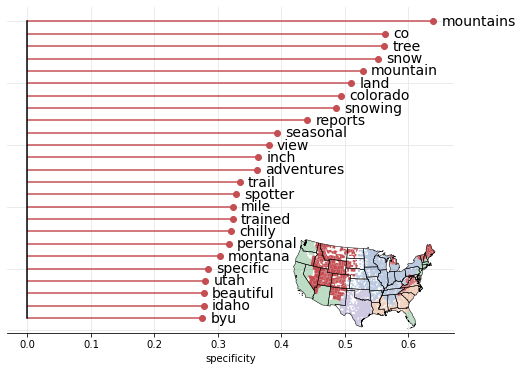

In [453]:
lvls_subset = [clust.levels[i] for i in (3, 7)]
lvl = lvls_subset[0]
# lvl.attr_color_to_labels()
# for cn in range(1, 6):
# clust_nr = str(cn)
clust_nr = '4'
fig, ax = plt.subplots(figsize=(8, 6))
for clust_nr, df in spec_words_df.loc[spec_words_df['clust_nr'] == clust_nr].groupby('clust_nr').head(25).groupby('clust_nr'):
    c = level.colors[clust_nr]
    y_pos = df.shape[0] - np.arange(df.shape[0]) #df['y_pos'].values
    heads = df['spec'].values
    markerline, stemlines, baseline = ax.stem(
        y_pos, heads, orientation='horizontal', basefmt='k-' #'none'
    )
    stemlines.set_color(c)
    markerline.set_color(c)
    words = df.index
    x_annot_offset = heads.max() * 0.02
    for w, x, y in zip(words, heads, y_pos):
        ax.annotate(w, (x + x_annot_offset, y), ha='left', va='center',
                    annotation_clip=False, fontsize=14)

ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.grid(True, color=[0.9]*3 + [0.4])
ax.tick_params(axis='y', left=False, labelleft=False)
# ax.set_yticks(
#     sorted(spec_words_df['y_pos'].values, reverse=True), labels=stem_data.index.values, ha='left')
ax.set_xlabel('specificity')

axins = ax.inset_axes([0.5, 0, 0.6, 0.3])
for key, c in lvl.colors.items():
    alpha = 1 if key == clust_nr else 0.4
    lvl.colors[key] = (*c[:3], alpha)
_, _ = map_viz.cluster_level(
    lvl, lang.regions, axes=axins, show=False, show_lgd=False, plot={'rasterized': True}
)
lvl.colors = {key: (*color[:3], 1) for key, color in lvl.colors.items()}
axins.set_title(None)
fig.savefig(lang.paths.case_figs / f'words_clust{clust_nr}_lvl3.pdf',
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(17.8/2.54, 19/2.54), constrained_layout=True, dpi=300)
top, bot = fig.subfigures(nrows=2, ncols=1, height_ratios=[1, 1.6]) #, wspace=0.2)
axd = top.subplot_mosaic(
    [['a', 'b']], gridspec_kw={'width_ratios': [2.2, 1]},
)
axd.update(bot.subplot_mosaic(
    [['c', 'd']], # gridspec_kw={'width_ratios': [1.5, 1]},
))
# fig.set_constrained_layout_pads(w_pad=0, wspace=0)
# lvls_subset = [clust.levels[i] for i in (3, 7)]

# for ax_key, lvl in zip(['a', 'b'], lvls_subset):
ax = axd['a']
lvl = level
lvl.attr_color_to_labels()
# map_lgd_kwargs = {'bbox_transform': ax.transAxes, 'bbox_to_anchor': (0.95, 0.5),
#                   'loc': 'center left', }
map_lgd_kwargs = {'bbox_transform': ax.transAxes, 'bbox_to_anchor': (0, -0.1),
                  'loc': 'lower left', 'ncol': 2}
_, _ = map_viz.cluster_level(
    lvl, lang.regions, axes=ax, plot={'rasterized': True}, legend=map_lgd_kwargs, show=False
)
ax.set_title(None)

ax = axd['c']
for clust_nr, df in spec_words_df.groupby('clust_nr').head(5).groupby('clust_nr'):
    c = level.colors[clust_nr]
    y_pos = df['y_pos'].values
    heads = df['spec'].values
    markerline, stemlines, baseline = ax.stem(
        y_pos, heads, orientation='horizontal', basefmt='k-' #'none'
    )
    stemlines.set_color(c)
    markerline.set_color(c)
    words = df.index
    for w, x, y in zip(words, heads, y_pos):
        ax.annotate(w, (x+0.1, y), ha='left', va='center', annotation_clip=False)

ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.grid(True, color=[0.9]*3 + [0.4])
ax.tick_params(axis='y', left=False, labelleft=False)
# ax.set_yticks(
#     sorted(spec_words_df['y_pos'].values, reverse=True), labels=stem_data.index.values, ha='left')
ax.set_xlabel('specificity')

ax = axd['d']
_, ax = clust.plot_dendrogram(coloring_lvl=3, ax=ax, orientation='left')
ax.set_yticks([])
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Euclidean distance')
# ax.set_axis_off()

ax = axd['b']
_, ax = clust.score_plot(ax=ax, show=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks([lvl.nr_clusters for lvl in clust.levels])
ax.set_title(None)

for key, ax in axd.items():
    annot_pos = (0, 1)
    if key == 'b':
        annot_pos = (-0.5, 1)
    art = ax.annotate(f'({key})', annot_pos, xycoords='axes fraction', size=14)

# save_path = lang.paths.case_figs / 'clust.pdf'
fmt_dict = {**lang.to_dict(),
            **asdict(decomp),
            **decomp.word_counts_vectors.to_dict(),
            **decomp.word_vectors.to_dict(),
            **asdict(level)}
save_path = Path(str(lang.paths.cluster_fig_fmt).format(**fmt_dict))
fig.savefig(save_path)
fig.savefig(save_path.with_suffix('.png'))
fig.set_dpi(50)
fig.show()

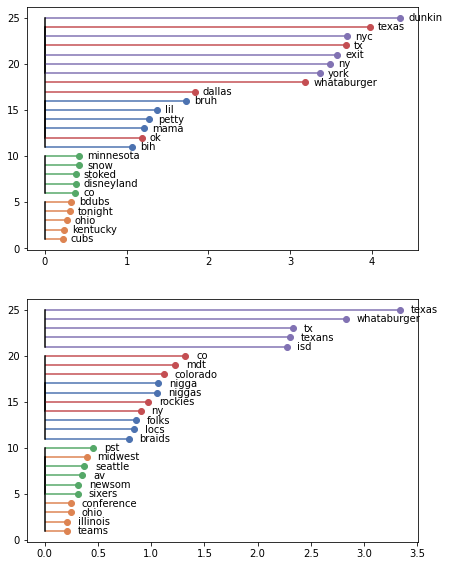

In [261]:
fig, axes = plt.subplots(2, figsize=(17.8/2.54, 12.5*2/2.54))

for i_lang, ax in zip([0, -2], axes):
    lang = list_langs[i_lang]
    i_decompo = 0
    decomp = lang.decompositions[i_decompo]
    i_clust = 0
    clust = decomp.clusterings[i_clust]
    i_lvl = 3
    level = clust.levels[i_lvl]
    clust_words = lang.get_clust_words(i_decompo=i_decompo, i_clust=i_clust, i_lvl=i_lvl)

    list_df = []
    # for clust_nr, clust_stem_data in stem_data.groupby('cluster'):
    for clust_nr in level.labels.unique():
        coord_col = f'cluster{clust_nr}'
        dist_col = f'dist{clust_nr}'
        clust_words[f'spec{clust_nr}'] = clust_words[dist_col]
        top_words_spec = clust_words.loc[clust_words[coord_col] > 0, f'spec{clust_nr}'].rename('spec').nlargest(n=5)
        # top_words_spec = clust_words[f'spec{clust_nr}'].rename('spec').nlargest(n=5)
        # mask = clust_words.loc[top_words_spec.index, f'cluster{clust_nr}'] < 0
        # top_words_spec.loc[mask] = -top_words_spec.loc[mask]
        df = pd.DataFrame({'spec': top_words_spec, 'clust_nr': clust_nr}, index=top_words_spec.index)
        list_df.append(df)

    spec_words_df = pd.concat(list_df)
    spec_words_df['y_pos'] = spec_words_df['spec'].abs().rank()

    for clust_nr, df in spec_words_df.groupby('clust_nr'):
        c = level.colors[clust_nr]
        y_pos = df['y_pos'].values
        heads = df['spec'].values
        markerline, stemlines, baseline = ax.stem(
            y_pos, heads, orientation='horizontal', basefmt='k-' #'none'
        )
        stemlines.set_color(c)
        markerline.set_color(c)
        words = df.index
        # CAREFUL here, if text placed too much on the right it disapeears (??)
        for w, x, y in zip(words, heads, y_pos):
            ax.annotate(w, (x+0.1, y), ha='left', va='center')

Year by year maps

In [ ]:
for l in list_langs[1:]:
    decomp = l.decompositions[0]
    clust = decomp.clusterings[-1].levels[3]
    _, ax = clust.silhouette_plot(decomp.proj_vectors)
    ax.set_title(f'{l.year_from}-{l.year_to}')

In [ ]:
for l in list_langs[:-1]:
    clust = l.decompositions[0].clusterings[-1]
    _, ax = clust.score_plot()
    ax.set_title(f'{l.year_from}-{l.year_to}')

In [ ]:
for l in list_langs[1:]:
    clust = l.decompositions[0].clusterings[-1]
    _, ax = clust.score_plot()
    ax.set_title(f'{l.year_from}-{l.year_to}')

TODO: word distrib of freqs for some examples

Video

In [520]:
from matplotlib.collections import PatchCollection
import matplotlib.animation as manimation

In [516]:
common_cells = pd.Series(1, index=window_langs[0].relevant_cells)
for l in window_langs[1:]:
    common_cells = common_cells.add(pd.Series(1, index=l.relevant_cells))
common_cells = common_cells.loc[common_cells.notnull()].index

In [ ]:
interact_viz.clusters(reg.cells_geodf.loc[common_cells], level.labels)

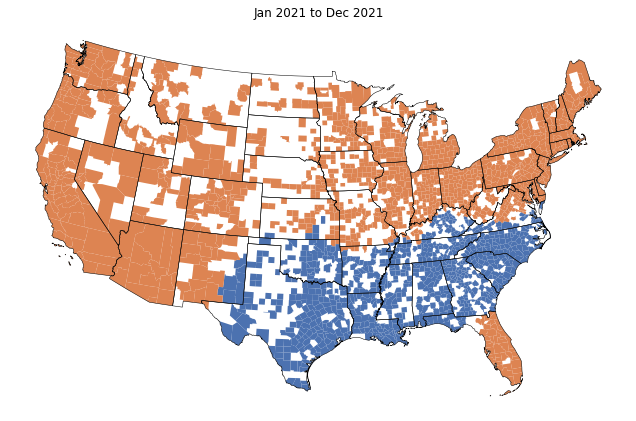

In [653]:
fig, ax = plt.subplots(1, figsize=(1280/100, 720/100))
ilvl = 0
# clust_locs = {'1': 22075, '2': 26021, '3': 36047, '4': 48061, '5': 30083}
clust_locs = {'1': 22075, '2': 36047} 
first_lang = window_langs[0]
reg = first_lang.regions[0]
level = first_lang.decompositions[1].clusterings[0].levels[ilvl]
level.attr_color_to_labels()
label_color = level.colors
cc_geodf = reg.cells_geodf.loc[common_cells].join(level.labels.astype(int), how='inner')
for lbl, loc in clust_locs.items():
    mask = cc_geodf['labels'] == cc_geodf.loc[loc, 'labels']
    cc_geodf.loc[mask, 'normed_labels'] = int(lbl)
# loc_always_north = cc_geodf.loc[cc_geodf['state_name'] == 'Vermont'].index[0]
# north_mask = cc_geodf['labels'] == cc_geodf.loc[loc_always_north, 'labels']
# cc_geodf.loc[north_mask, 'labels'] = 1
# cc_geodf.loc[~north_mask, 'labels'] = 2
cmap = mcolors.ListedColormap(list(label_color.values()))
# cmap, norm = mcolors.from_levels_and_colors(range(len(label_color) + 1), list(label_color.values()))
# Don't put a cmap in kwargs['plot'] because here we use a
# fixed color per cluster.
cc_geodf.plot(
    column='normed_labels', ax=ax, cmap=cmap, #norm=norm
)

reg.shape_geodf.plot(
    ax=ax, color='none', edgecolor='black', linewidth=0.5,
)
date_from = datetime.date(first_lang.year_from, first_lang.month_from, 1)
date_to = datetime.date(first_lang.year_to, first_lang.month_to, 1)
title = ax.set_title(f"{date_from.strftime('%b %Y')} to {date_to.strftime('%b %Y')}")
ax.set_axis_off()
for c in ax.get_children():
    if isinstance(c, PatchCollection):
        arr = c.get_array()
        if arr is not None and len(arr) > 0:
            collec = c
geoms, multiindex = geopd.plotting._flatten_multi_geoms(cc_geodf.geometry)

def animate(i, window_langs, multiindex):
    l = window_langs[i]
    date_from = datetime.date(l.year_from, l.month_from, 1)
    date_to = datetime.date(l.year_to, l.month_to, 1)
    title.set_text(f"{date_from.strftime('%b %Y')} to {date_to.strftime('%b %Y')}")
    clust = l.decompositions[1].clusterings[0].levels[ilvl]
    labels = clust.labels.loc[common_cells].astype(int)
    normed_labels = labels.copy()
    for lbl, loc in clust_locs.items():
        mask = labels == labels.loc[loc]
        normed_labels.loc[mask] = int(lbl)
    # north_mask = labels == labels.loc[loc_always_north]
    # labels.loc[north_mask] = 1
    # labels.loc[~north_mask] = 2
    collec.set_array(normed_labels.values[multiindex])
    return collec, title

anim_args = np.arange(len(window_langs))
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = manimation.FuncAnimation(
    fig, animate, anim_args, fargs=[window_langs, multiindex],
    interval=500, blit=True, repeat=False
)
anim.save(f'US_clusters_lvl{ilvl}.mp4', dpi=200)

In [582]:
first_lang = window_langs[0]
reg = first_lang.regions[0]
decomp = first_lang.decompositions[0]
level = decomp.clusterings[0].levels[0]
first_labels = level.labels.loc[common_cells].astype(int)
ami_evol = []
for l in window_langs[1:]:
    reg = l.regions[0]
    decomp = l.decompositions[0]
    level = decomp.clusterings[0].levels[0]
    labels = level.labels.loc[common_cells].astype(int)
    ami = sklearn.metrics.adjusted_mutual_info_score(first_labels, labels)
    ami_evol.append(ami)

In [ ]:
dt_plot = [datetime.date(l.year_from, l.month_from, 1) for l in window_langs[1:]]
plt.scatter(dt_plot, ami_evol)

In [677]:
def get_diff(l, loc_always_north, i_decomp=0, i_clust=0, i_level=0):
    decomp = l.decompositions[i_decomp]
    level = decomp.clusterings[i_clust].levels[i_level]
    is_north = level.labels == level.labels.loc[loc_always_north]
    south_center = np.mean(decomp.proj_vectors[np.nonzero(~is_north.values)[0]], axis=0)
    north_center = np.mean(decomp.proj_vectors[np.nonzero(is_north.values)[0]], axis=0)
    dist_df = pd.DataFrame(
        {
            'south': np.sum((decomp.proj_vectors - south_center)**2, axis=1),
            'north': np.sum((decomp.proj_vectors - north_center)**2, axis=1)
        },
        index=l.relevant_cells,
    )
    diff = dist_df['south'] - dist_df['north']
    return diff

In [ ]:
fig, ax = plt.subplots(1, figsize=(1280/100, 720/100))
loc_always_north = cc_geodf.loc[cc_geodf['state_name'] == 'Vermont'].index[0]
first_lang = window_langs[0]
reg = first_lang.regions[0]
# plot_series = get_diff(first_lang, loc_always_north)
plot_series = pd.Series(
    first_lang.decompositions[0].proj_vectors[:, 0], index=first_lang.relevant_cells, name='comp0'
)
if plot_series.loc[loc_always_north] > 0:
    plot_series = - plot_series
cc_geodf = reg.cells_geodf.loc[common_cells].join(plot_series, how='inner')
cmap = 'bwr'
norm = mcolors.TwoSlopeNorm(
    vcenter=0, vmin=plot_series.min(), vmax=plot_series.max()
)
# cmap = mcolors.ListedColormap(list(label_color.values()))
# cmap, norm = mcolors.from_levels_and_colors(range(len(label_color) + 1), list(label_color.values()))
# Don't put a cmap in kwargs['plot'] because here we use a
# fixed color per cluster.
cc_geodf.plot(
    column=plot_series.name, ax=ax, cmap=cmap, legend=True, norm=norm
)
reg.shape_geodf.plot(
    ax=ax, color='none', edgecolor='black', linewidth=0.5,
)
# fig.colorbar(ax=ax)
date_from = datetime.date(first_lang.year_from, first_lang.month_from, 1)
date_to = datetime.date(first_lang.year_to, first_lang.month_to, 1)
title = ax.set_title(f"{date_from.strftime('%b %Y')} to {date_to.strftime('%b %Y')}")
ax.set_axis_off()
for c in ax.get_children():
    if isinstance(c, PatchCollection):
        arr = c.get_array()
        if arr is not None and len(arr) > 0:
            collec = c
geoms, multiindex = geopd.plotting._flatten_multi_geoms(cc_geodf.geometry)

def animate(i, window_langs, multiindex):
    l = window_langs[i]
    date_from = datetime.date(l.year_from, l.month_from, 1)
    date_to = datetime.date(l.year_to, l.month_to, 1)
    title.set_text(f"{date_from.strftime('%b %Y')} to {date_to.strftime('%b %Y')}")
    # plot_series = get_diff(l, loc_always_north)
    plot_series = pd.Series(
        l.decompositions[0].proj_vectors[:, 0], index=l.relevant_cells, name='comp0'
    )
    if plot_series.loc[loc_always_north] > 0:
        plot_series = - plot_series
    collec.set_array(plot_series.loc[common_cells].values[multiindex])
    return collec, title

anim_args = np.arange(len(window_langs))
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = manimation.FuncAnimation(
    fig, animate, anim_args, fargs=[window_langs, multiindex],
    interval=500, blit=True, repeat=False
)
anim.save(first_lang.paths.case_figs.parent / 'comp0.mp4', dpi=200)

Proportion map of black population from census

In [339]:
import census

In [352]:
c = census.Census(os.environ['US_CENSUS_KEY'], year=2018)

In [361]:
pop_by_county = c.acs5.get(('B02001_001E', 'B02001_003E'), {'for': 'county:*'})

In [389]:
census_df = pd.DataFrame.from_records(pop_by_county).rename(columns={'B02001_001E': 'total', 'B02001_003E': 'black'})
census_df['black_prop'] = census_df['black'] / census_df['total']
census_df.index = (census_df['state'] + census_df['county']).astype(int)

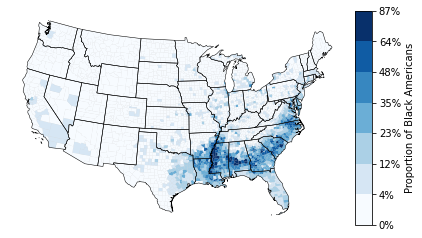

In [421]:
import mapclassify
from matplotlib.colors import BoundaryNorm
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
            
fig, axes = plt.subplots(1, figsize=(17.8/2.54, 10/2.54))
binning = mapclassify.classify(
    np.asarray(census_df['black_prop']), 'NaturalBreaks', **{'k': 7}
)
bounds = binning.bins
lowest = binning.y.min()
bounds = np.insert(binning.bins, 0, lowest)
norm = BoundaryNorm(bounds, binning.k)
cmap = cm.get_cmap('Blues', binning.k)
fig, axes = lang.map_continuous_choro(
    census_df['black_prop'], axes=axes, normed_bboxes=False, cmap=cmap, norm=norm, 
    cbar_kwargs={'format': PercentFormatter(xmax=1.)},
    cbar_label='Proportion of Black Americans',
    save_path=lang.paths.case_figs / 'census18_black_prop.pdf'
)